#Homework 5: Confusion Matrix. ROC. AUC.

# Part 1
You will predict for an insuarance company how likely the person will be admitted to a hospital within the next year `DaysInHospital_Y2.csv`. The following data is provided: paitients' information `Members.csv` (age, sex) medical services provided in the previous year `Claims_Y1.csv` (provider, doctor, illness, days in hospital, etc. ).
Data source: https://www.kaggle.com/competitions/hhp/overview

You can dounload files directly from https://github.com/truongkhanhduy95/Heritage-Health-Prize/tree/master/data (click *Raw data* and copy the path). **If you use this repo, use 'Claims.csv' instead of 'Claims_Y1.csv'**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#1. (2pt) Read the data using parameter index_col = `MemberID`.

* table 'DaysInHospital_Y2.csv' into variable `days2`
* table 'Members.csv' into variable `m`
* table 'Claims_Y1.csv' into variable `claims`

In [2]:
path = 'https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/'

In [3]:
m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m.head()

,AgeAtFirstClaim,Sex
MemberID,,
14723353,70-79,M
75706636,70-79,M
17320609,70-79,M
69690888,40-49,M
33004608,0-9,M


In [4]:
claims=pd.read_csv(path+'Claims.csv',index_col='MemberID')
claims.head()

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [5]:
days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2.head()

,ClaimsTruncated,DaysInHospital
MemberID,,
24027423,0,0
98324177,0,0
33899367,1,1
5481382,0,1
69908334,0,0


To anonymize the data, the organizer provided approximate information about patients, for example, in the Age column, age groups are specified: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. We will convert string features into numerical ones and replace missing values.

In [6]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

Let's construct features based on the array of medical service cases:
* `f_Charlson` — the maximum Charlson comorbidity index among all cases for the patient (`CharlsonIndex` in the table `claims`)
* `f_LengthOfStay` —  the total number of hospitalization days in the past year  (`LengthOfStay` in the table `claims`)


In [7]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

We will create a feature matrix with the following columns: `f_Charlson`, `f_LengthOfStay`, `AgeAtFirstClaim`, `ClaimsTruncated` (whether there were too many medical service cases).

In [8]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,
24027423,0,3,0,30
98324177,0,0,0,30
33899367,1,0,0,80
5481382,0,0,1,20
69908334,0,1,0,60


## 2. (1pt) Add to the features columm `Sex`

In [9]:
X = X.join(m.Sex)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
24027423,0,3,0,30,M
98324177,0,0,0,30,M
33899367,1,0,0,80,F
5481382,0,0,1,20,F
69908334,0,1,0,60,F


## 3. (1pt) Split the date X and y into Train/Validation/Test sets in the following proportion: 50/25/25.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

##4. (1pt) The column `Sex` contains missing values. Create the column transformer that will apply One-Hot-Encoder to this column with parameter `handle_unknown='infrequent_if_exist'`. It will create automatically `'OneHot__Sex_nan'` column afer fitting this transformer on the Train set. (Don't forget parameter `reminder`)

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [13]:
#Transform categorical into nominal
onee = OneHotEncoder(handle_unknown='infrequent_if_exist')
transform = ColumnTransformer(transformers=[('one-hot', onee, ['Sex'])], remainder='passthrough')
transform.fit(X_train, y_train)

# X_train_hot = pd.DataFrame(transform.transform(X_train), columns=transform.get_feature_names_out())
# X_test_hot = pd.DataFrame(transform.transform(X_test), columns=transform.get_feature_names_out())
# X_train_hot.head()

ColumnTransformer(remainder='passthrough',
                  transformers=[('one-hot',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                 ['Sex'])])

## 5. (1pt) Create a pipeline for training logistic regression. It should include transformation, scaling, and model. And fit it on the Training set

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [33]:
pipe = Pipeline([('transform', transform), ('sc', StandardScaler()), ('classifier', LogisticRegression())])

In [34]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Sex'])])),
                ('sc', StandardScaler()),
                ('classifier', LogisticRegression())])

## 6. (2pt) Plot ROC-AUC and Confusion Matrix. Report the Recall value.

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, RocCurveDisplay, precision_recall_curve, precision_score

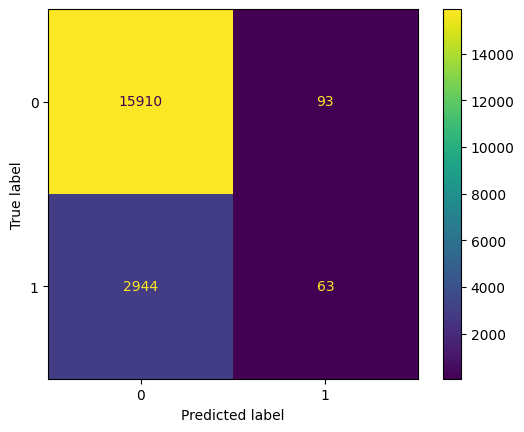

In [36]:
ConfusionMatrixDisplay.from_predictions(y_val, pipe.predict(X_val))

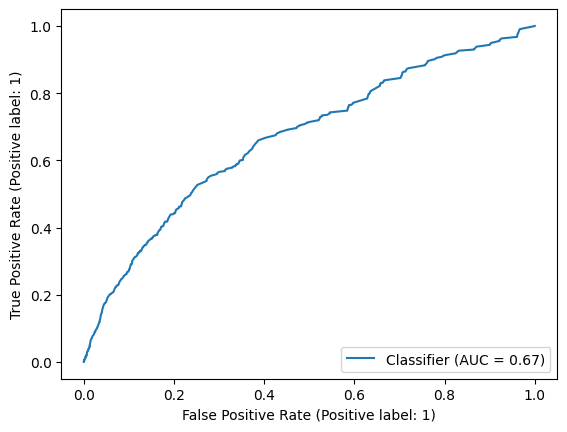

In [37]:
y_pred_proba = pipe.predict_proba(X_val)[:,1]
RocCurveDisplay.from_predictions(y_val, y_pred_proba)

In [38]:
print(f"Recall value: {recall_score(y_val, pipe.predict(X_val))}")

Recall value: 0.020951114067176587


## 7. (4pt) Use `.predict_proba` to get the values in the interval $[0,\ 1]$ instead of the classes 0 or 1.

Choose the threshold, such that recall on the Validation set is $>0.5$ (Think about this as the insuarance company's requirement.)

For the chosen threshold plot ROC-AUC (it won't change because the model stays unchanged) and Confusion Matrix. Report the Recall value.

In [39]:
threshold = 0.12 #my chosen threshold such that the recall is > 0.5

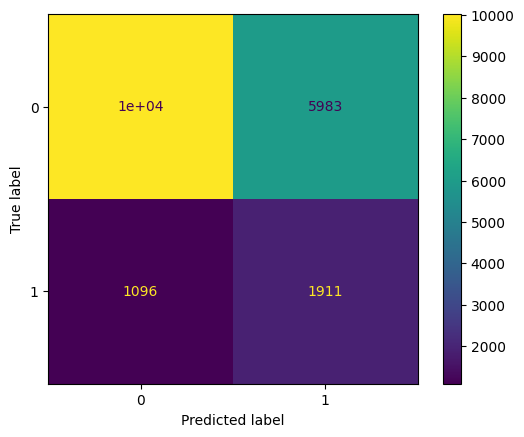

In [40]:
ConfusionMatrixDisplay.from_predictions(y_val, (y_pred_proba > threshold).astype(int))

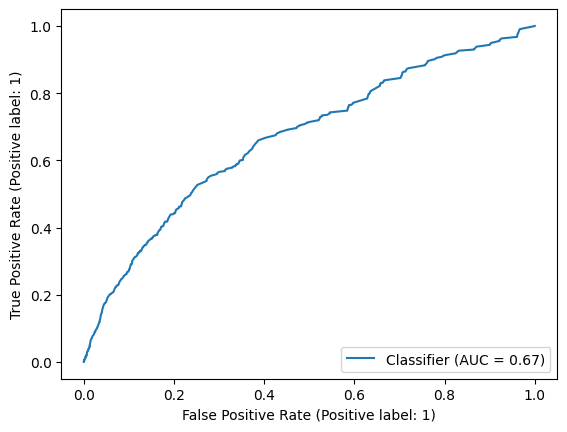

In [41]:
RocCurveDisplay.from_predictions(y_val, y_pred_proba)

In [42]:
print(f"Recall value: {recall_score(y_val, (y_pred_proba > threshold).astype(int))}")

Recall value: 0.6355171267043564


## 8. (1 pt) Finally, plot ROC-AUC and Confusion Matrix, and report the Recall value on the Test set.

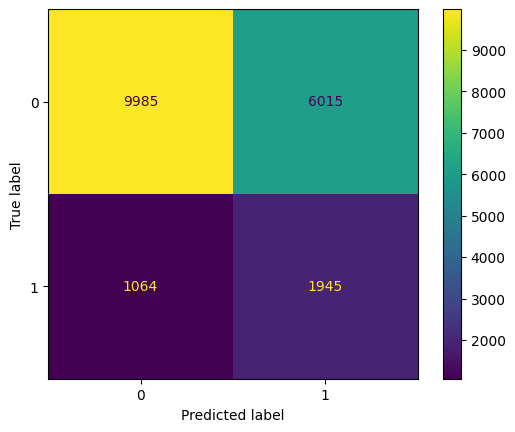

In [43]:
y_pred_proba = pipe.predict_proba(X_test)[:,1]
ConfusionMatrixDisplay.from_predictions(y_test, (y_pred_proba > threshold).astype(int)) #this line

# I used the confusion matrix for test set WITH the threshold, I'm assuming the question wanted us to carry
# through our changes from question 7. However in case it did not, the line below would simply replace the line above
# tagged with "this line" to have a confusion matrix without the threshold. Same thing for the recall value.

#RocCurveDisplay.from_predictions(y_test, y_pred_proba)

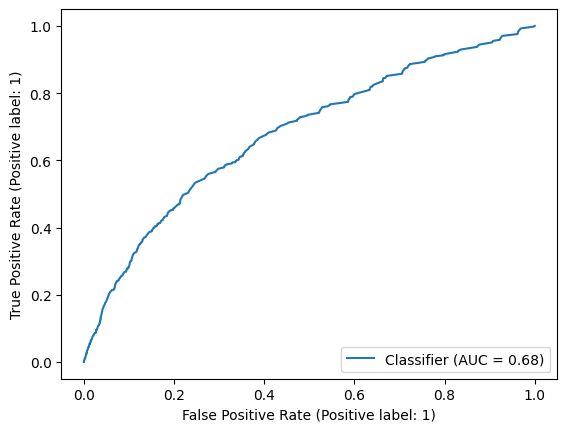

In [44]:
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

In [48]:
print(f"Recall value: {recall_score(y_test, (y_pred_proba > threshold).astype(int))}")

#print(f"Recall value: {recall_score(y_test, pipe.predict(X_test))}")

Recall value: 0.6463941508806913


## 9. (1pt) Which features are more important?

In [54]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, r_regression, f_regression

X_train_hot = pd.DataFrame(transform.transform(X_train), columns=transform.get_feature_names_out())

selector_MI = SelectKBest(mutual_info_regression, k=7)
selector_MI.fit_transform(X_train_hot, y_train)


selected_feature_indices_sorted = np.argsort(selector_MI.scores_)[::-1][:7]
selected_feature_names_sorted = X_train_hot.columns[selected_feature_indices_sorted]

print("Selected features sorted by importance:")
print(selected_feature_names_sorted)

Selected features based on mutual information (sorted by importance):
Index(['remainder__LengthOfStay', 'remainder__CharlsonIndex',
       'remainder__AgeAtFirstClaim', 'remainder__ClaimsTruncated',
       'one-hot__Sex_nan', 'one-hot__Sex_M', 'one-hot__Sex_F'],
      dtype='object')


#Part 2
##10. (5pt)

Discuss the effectiveness of each of the following ML models based on their stated accuracy. Which one is the best overall?

**a.** In a roulette game, a ball is dropped onto a spinning wheel and eventually lands in one of 38 slots. Using a camera and visual cues (the position of the wheel when the ball was dropped and its rotation speed, as well as the position and speed of the ball), an ML model can predict the slot that the ball will land in with an accuracy of 4%.

  ***If we were to randomly guess where the ball would land then we would have a 2.63% chance of being right. A 4% accuracy however is technically a 69.49% improvement over randomly guessing. Whilst it may be a big improvement relatively to randomly guessing, overall a 4% accuracy is not that good.***



**b.** A robotic chicken crosses a busy road a thousand times per day. An ML model evaluates traffic patterns and predicts when this chicken can safely cross the street with an accuracy of 99.9%.

***If a chicken crosses the road 1000 times per day and we have a model with 99.9% accuracy, that means the chicken will only get hit 1 time per day. This is a pretty good model, albeit the consequences of that 0.01% inaccuracy in this scenario will result in a death of a chicken. However in general this model is pretty good at predicting when it's safe to cross the street.***



**c.** A deadly but curable disease affects 0.01% of the population. An ML model uses the results of a simple lab test as features and predicts this affliction with an accuracy of 99.99%.

***This will depend on if the accuracy is 99.99% accurate on true positives. If it is, then this is a fantastic model and should be used worldwide. However if it only mostly predicts negatives and generates false positives, it's usefulness diminshes due to potential harm from unecessary treatments. The high accuracy is desirable and good, but it's effectiveness depends on minimizing false positives in this clinical scenario.***


***The best model overall would be the deadly disease prevention model. The consequences of a misdiagnosis in that small 0.01% are much smaller than the consequences of guessing a wrong time of when it's safe to cross the street. One can result in death whilst the other one is much less likely. The gambling 4% model is just bad in accuracy compared to the other two. Thus the disease identification model is the best overall for it's practicality and utility.***
##11. (1pt)
The KNN model appears simpler than logistic regression, or linear regression for classification, or SVM. Why is the separating surface in KNN more complex than in the case of linear models?

***Linear models end up drawing a clear boundary based on the relationship in the points where one side is class A and the other is class B. On the otherhand, KNN  doesn't do this clean separation, and instead relies on using the training data to make predictions directly per each data point. It doesn't rely on predefined decision boundaries, it's dynamic in nature. This is why it's more complex than linear models albeit it appears simpler.***